## Modeling a quadrant cell photodiode:
## Implications for position measurement & spurious signal frequency components
### Paul Nakroshis, Kristen Gardner and Benjamin Montgomery
### Dept. of Physics, University of Southern Maine
#### Modified 3 March  2019

##### Abstract
This notebook discusses the response of a circular quandrant cell photodiode to the passage
of a gaussian laser beam across it's surface. We show that the detector can be successfully modeled 
by a straightforward numerical integration over the surface, and that the full width at half maximum can be
determined by manually displacing the detector and adjusting the simulation beam width parameter to fit the actual data. 
It turns out that the detector response is critically dependent upon the FWHM of the beam, and for beam diameters small relative to the detector diameter, the response curve changes in shape from roughly sinusoidal to something more akin to a square wave. This has important implications for the power spectrum of the signal, as spurious non-trivial frequencies are induced due to this behavior. 

In [2]:
#### Load needed libraries and setup plot styles
####
#  Uncomment the next line if you want to interact with the plots:
#%matplotlib ipympl
#  Otherwise (in jupyterlab), use non-interactive plots:
%matplotlib inline
#  Comment out the next line if you swith to interactive plots:
#%matplotlib notebook
#  If you are NOT using an Apple "Retina" display, comment out the next line:
%config InlineBackend.figure_format = 'retina'

# only execute this next line once 
# see https://nbviewer.jupyter.org/github/jrjohansson/version_information/blob/master/example.ipynb 
#for more info 
#!pip install --upgrade version_information  
%load_ext version_information
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from numba import jit
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
import numpy as np
import time
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
plt.rcParams["figure.figsize"] = [9,6]
import pandas as pd
from QuadCellDetector_Spyder import physics as phy
%version_information

Software versions
Python 3.7.1 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
Sun Mar 03 19:10:47 2019 EST

## Detector Geometry
To model our detector, we create a planar space with bounds $(-x_{\textrm{max}}, -y_{\textrm{max}})$ to  $(+x_{\textrm{max}}, +y_{\textrm{max}})$ with the circular detector centered on the origin. Our detector is a quadrant cell photodiode with diameter $d_0 = 7.80\;\textrm{mm}$ and an inactive gap between the cells of width $\delta = 42\;\mu\textrm{m}$. If we break up the detector by a square grid of size $\Delta = \frac{d_0}{n}$, then the cells bordering the gap will have to have an area $\frac{\delta}{2}\Delta$ subtracted from the cell area $da = \Delta^2$. Note that the four cells centered on the origin are exceptions to this, and will have a dead area of $2(\frac{\delta}{2}\Delta)$ subtracted from $\Delta^2$:<br/>
<br/>

<img src="drawings/DetectorGeometryOverview.png" style="float: center;" width="500">

The figure above assumes that the grid size is greater than the gap width, or $\Delta < \delta$, and therefore there  are two rows and two columns of cells that are affected by the dead area. However, to create an accurate model of the detector, we want to choose a gride size sufficiently small so that we can better approximate a true integration of the light intensity. A better scenario, then is to conside a situation like this where the grid size is smaller than the gap:<br/>
<br/>

<img src="drawings/detector.png" style="float:center;" width="500">

So there are two general situations (again, assuming that the detector cells are such that the closest cells' centers are $\Delta/2$ away from the coordinate axes.)<br/>
1. if $\Delta >\frac{\delta}{2}$, then there are only two rows and two columns of cells affected by the dead zone gap, and
2. if $\Delta <\frac{\delta}{2}$, then there are $4N_{\textrm{a}}$ rows/columns affected, where $N_{\textrm{a}}$ is the number of cells' centers within 
   $\frac{\delta}{2} + \frac{\Delta}{2}$; in practice, the condition for a cell to be affected by the dead zone is if $x - \frac{\Delta}{2} < \frac{\delta}{2}$.
   
The electronic connection to the detector receives as input a photocurrent from each quadrant, and returns three signals: the sum of all four quadrants, the top two minus the bottom two, and the left two minus the right two. 

The laser used in our optical lever is a 4.9 mW gaussian beam photodiode from Edmund Optics (635nm, VHK Circular Beam Visible Laser Diode). The laser diode specs list the beam diameter of 1.1 mm at the aperature, but we have a 1.0 m focal length lens that focusses the spot onto our photodiode plane, resulting in a smaller beam (as we shall see, with $\sigma = 0.320$ mm (corresponding to a Full Width at Half Maximum (FWHM) ~ 2.355σ ~ 0.754 mm).

The goal of this notebook is to model the detector response to a gaussian beam of known width. Then, because our detector is mounted on a linear translation stage, we can move the actual beam across the detector and adjust beam width in the simulation until we match the actual signal from our detector. 

## Measured detector response
We fixed the laser beam position on the detector, and manually moved the detector plane (with a resolution of 0.01 mm) across the beam, recording the detector response. The first column is the actual micrometer reading in millimeters and the second column is the rescaled sensor position (where zero position is where the laser is centered on the detector. Here is the data:

In [3]:
# the data file has position in mm and detector voltage in volts
calibration_data = pd.read_csv('MeasuredData/DetectorPositionVoltageData.txt',\
                               delimiter=" ", names=['Micrometer', 'dx', 'T-B', 'dT-B'])
calibration_data.head()

,Micrometer,dx,T-B,dT-B
0,12.0,6.21,0.07,-0.005663
1,11.5,5.71,0.14,-0.011327
2,11.0,5.21,0.15,-0.012136
3,10.5,4.71,0.24,-0.019417
4,10.4,4.61,0.29,-0.023463


In [4]:
data_length = len(calibration_data)
x_max = calibration_data['dx'].max()  # I'll use this value later in our simulation of the detector
x_min = calibration_data['dx'].min()
print(x_min, x_max)
calibration_data.tail()

-4.79 6.21


,Micrometer,dx,T-B,dT-B
91,1.4,-4.39,-0.85,0.068770
92,1.3,-4.49,-0.45,0.036408
93,1.2,-4.59,-0.28,0.022654
94,1.1,-4.69,-0.21,0.016990
95,1.0,-4.79,-0.18,0.014563


Here is a plot of the actual detector response (where the signal response has been normalized)

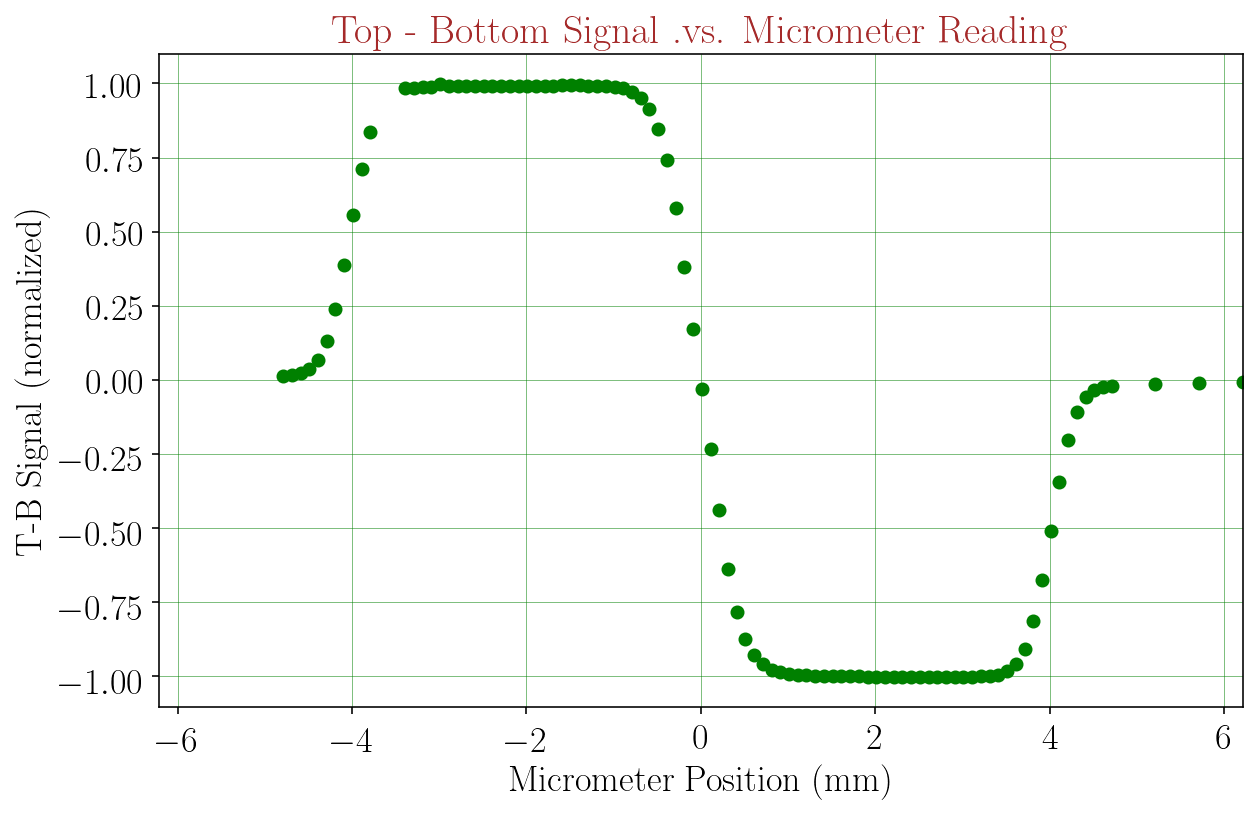

In [5]:
plt.close()
golden_ratio = (1+np.sqrt(5))/2
fig, ax = plt.subplots(figsize=(6*golden_ratio, 6))
ax.plot(calibration_data['dx'], calibration_data['dT-B'], 'go')
plt.title('Top - Bottom Signal .vs. Micrometer Reading', fontsize=20, color='Brown')
plt.ylabel('T-B Signal (normalized)', fontsize=18)
plt.xlabel('Micrometer Position (mm)', fontsize=18)
plt.xlim(-x_max, x_max)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.grid(color='green', linestyle='-', linewidth=0.25)
plt.show()

## Modeling our detector system
Now we need to simulate our detector system (the quadrant cell photodiode and the laser beam that drives it),
and try to achieve the same curve as measured above.
The functions that implement the scheme previously
described are contained in the file physics.py.
First we define our detector's diameter, gap size, and the radius of the simulated beam:

In [6]:
#########   Physical Paramaters for our detector system:
d0 = 7.80   # diameter of photocell in mm
δ = 0.042   # gap between the 4 quadrants; also in mm
σ = 0.320   # gaussian radius of our laser beam; adjust this to match actual data

Now we define the simulation parameters. The minimum number of cells to divide the detector into is defined by fitting at least
two cells within the gap distance, $\delta$, hence 
$$n_{\mathrm{critical}} = \frac{d_0}{\left(\delta/2\right)} = \frac{2d_0}{\delta};$$
the function n_critial makes sure that the number $n_{\mathrm{critical}}$ is even (to make sure our cell grid is centered symmetrically about $x=0$).
You'll notice I've introduced a variable $\epsilon$ (a "fudge factor"). This was a needed factor when deciding if a cell was in the gap region using a floating point comparison. The code in physics.create_detector needs this factor, and it is called be phy.signal_over_path. However, the code is set up to default to $\epsilon = 1e-14$; I just wanted to make this factor explicit, and it is so small as to be inconsequential in the end result.

In [7]:
#########   Simulation Parameters:
n = 2*phy.n_critical(d0, δ)   # choose a reasonable minimum n value
ϵ = 1E-14                     # fudge factor due to roundoff error in case where δ = 2Δ
Δ = d0/n                      # grid size for simulation
xmax = x_max                  # maximum horizontal displacement of beam from origin in actual data
n_samples = 2*data_length     # number of sample points set to twice the number as in actual data
track_func = phy.CENTER_PATH  # function in physics.py that describes the y coordinate of the beam 
#
print("Building: ", n, "by", n, " Array")
print("Pixel Size: Δ = %.6f " % (Δ))
print("Sampling response from -", xmax, " to +", xmax, " in ", n_samples, " steps")
#
#   Now build the detector and return the detector response for a gaussian
#   beam centered at (xc, yc) illumninating the detector. I will compute three different 
#   scenarios (different beam widths)
#   get the start time so we can time the code execution:
start_time = time.time()
   
xp, s, lr, tb = phy.signal_over_path(n, d0, δ, xmax, σ, track_func, n_samples,  ϵ)  # best guess to simulate the data; ϵ is an optional parameter
x_2sig, sum_2sig, lr_2sig, tb_2sig = phy.signal_over_path(n, d0, δ, xmax, 2*σ, track_func, n_samples, ϵ)  # simulation results for 2 times wider beam
x_3sig, sum_3sig, lr_3sig, tb_3sig = phy.signal_over_path(n, d0, δ, xmax, 3*σ, track_func, n_samples, ϵ)  # simulation results for 2 times wider beam
lr = lr/max(np.abs(lr))     # scale all three left minus right signals by the maximum value of the smallest beam radius.
lr_2sig = lr_2sig/max(np.abs(lr))
lr_3sig = lr_3sig/max(np.abs(lr))
print("Runtime = %s seconds ---" % round(time.time() - start_time, 2))

Building:  744 by 744  Array
Pixel Size: Δ = 0.010484 
Sampling response from - 6.21  to + 6.21  in  192  steps
Runtime = 24.04 seconds ---


Now plot the simulation results and overlay the actual data points for comparison. I've determined the best fit
by trial and error, placing visual concern over the linear portion in the center. The fact that the model doesn't fit 
the data as the spot moves off the detector may be due to light scattering as the beam leaves the detector, 
but this has not been verified. 

(* if using %matplotlib ipympl, the legend will not work; works fine for static figures via %matplotlib inline)

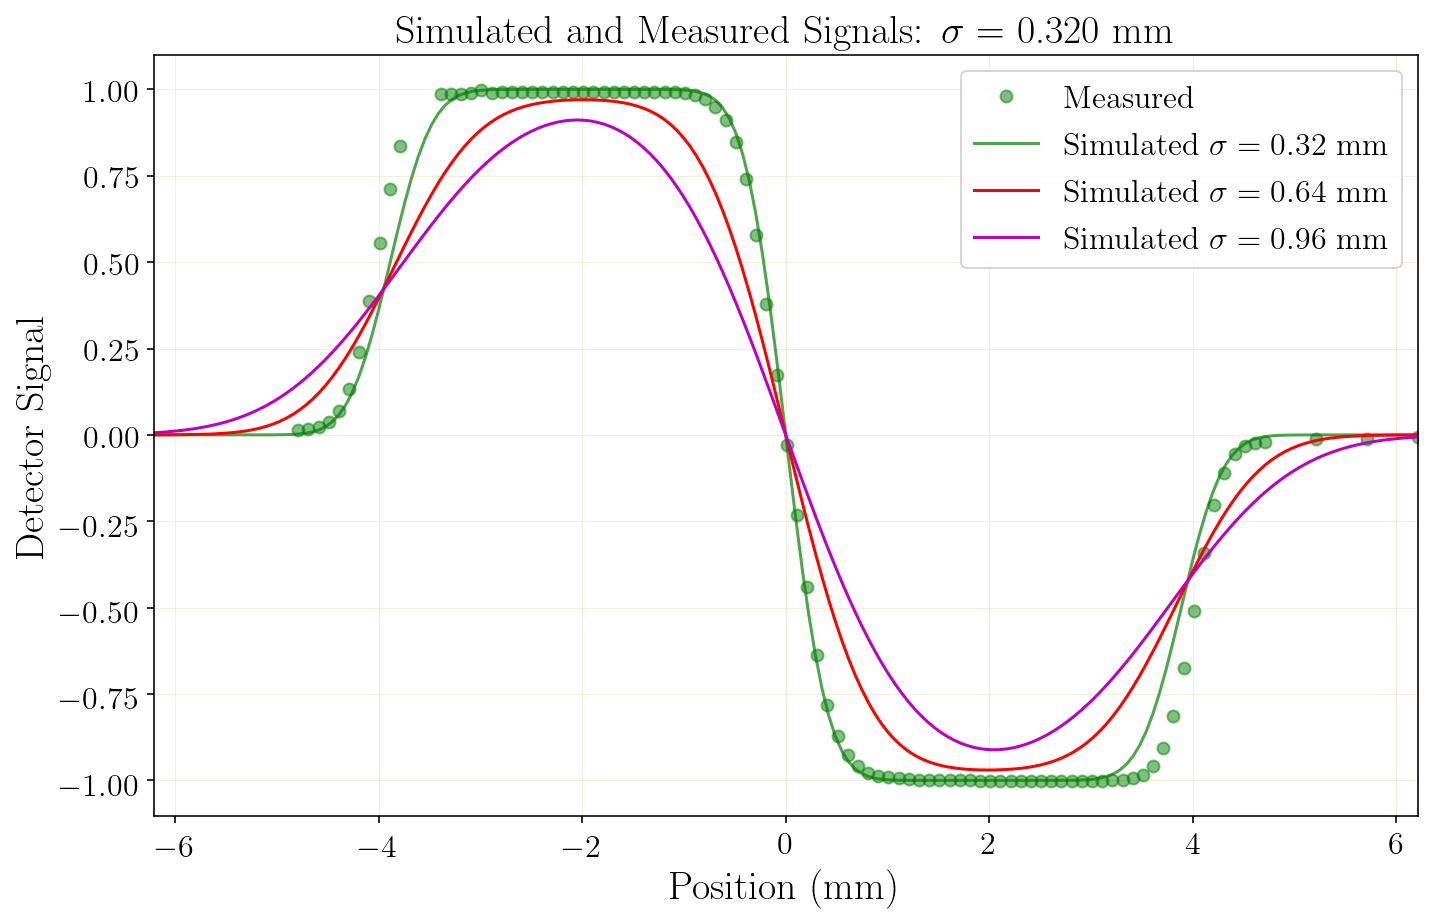

In [8]:
fig, ax = plt.subplots(figsize=(7*golden_ratio, 7))
ax.plot(calibration_data['dx'], calibration_data['dT-B'], 'go', label='Measured', alpha=0.5)
ax.plot(xp, lr, '-g', label='Simulated $\sigma = 0.32$ mm', alpha=0.7)
ax.plot(x_2sig, lr_2sig, '-r', label='Simulated $\sigma = 0.64$ mm')
ax.plot(x_3sig, lr_3sig, '-m', label='Simulated $\sigma = 0.96$ mm')

legend = ax.legend(loc='upper right', fontsize=16)
# Put a nicer background color on the legend.
#legend.get_frame().set_facecolor('darkgray')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel(r'Detector Signal', fontsize=20)
plt.xlabel(r'Position (mm)', fontsize=20)
plt.title(r'Simulated and Measured Signals: $\sigma$ = 0.320 mm', fontsize=20)
plt.xlim(-xmax, +xmax)
plt.grid(color='wheat', linestyle='-', linewidth=0.25)
plt.show()

### Comments on the simulation
The simulation seems to fit the data pretty well when $\sigma = 0.32\;\mathrm{mm}$; I've checked the simulation for different values of $\sigma$, and this value fits the central part of the detector data best. The extra signal on the outside shoulders is likely due to scattering of the laser beam off the edges of the detector as it enters or leaves the outer radius of the photodiode, although I haven't verified this conjecture yet.

### Common sense checks on the code: Qualitative
1. all signals go through the origin. By symmetry, if a gaussian beam travels straight across the detector, it must give zero signal at $x = 0$.
2. the signal decays to zero as it leaves the detector (obviously).
3. it makes sense that beam with radius small (but larger than the gap!) has a large left minus right signal that remains constant once it is fully on the detector. A larger beam will not have as high a maximum signal value because some of the laser light makes it to the right side of the detector and diminishes the signal as the beam approaches the origin. 
4. A gaussian beam width equal to the gap distance will still produce a signal, but will be significantly reduced (because some of the light falls outside the $1\sigma$ radius), as you can see if you execute the next cell.

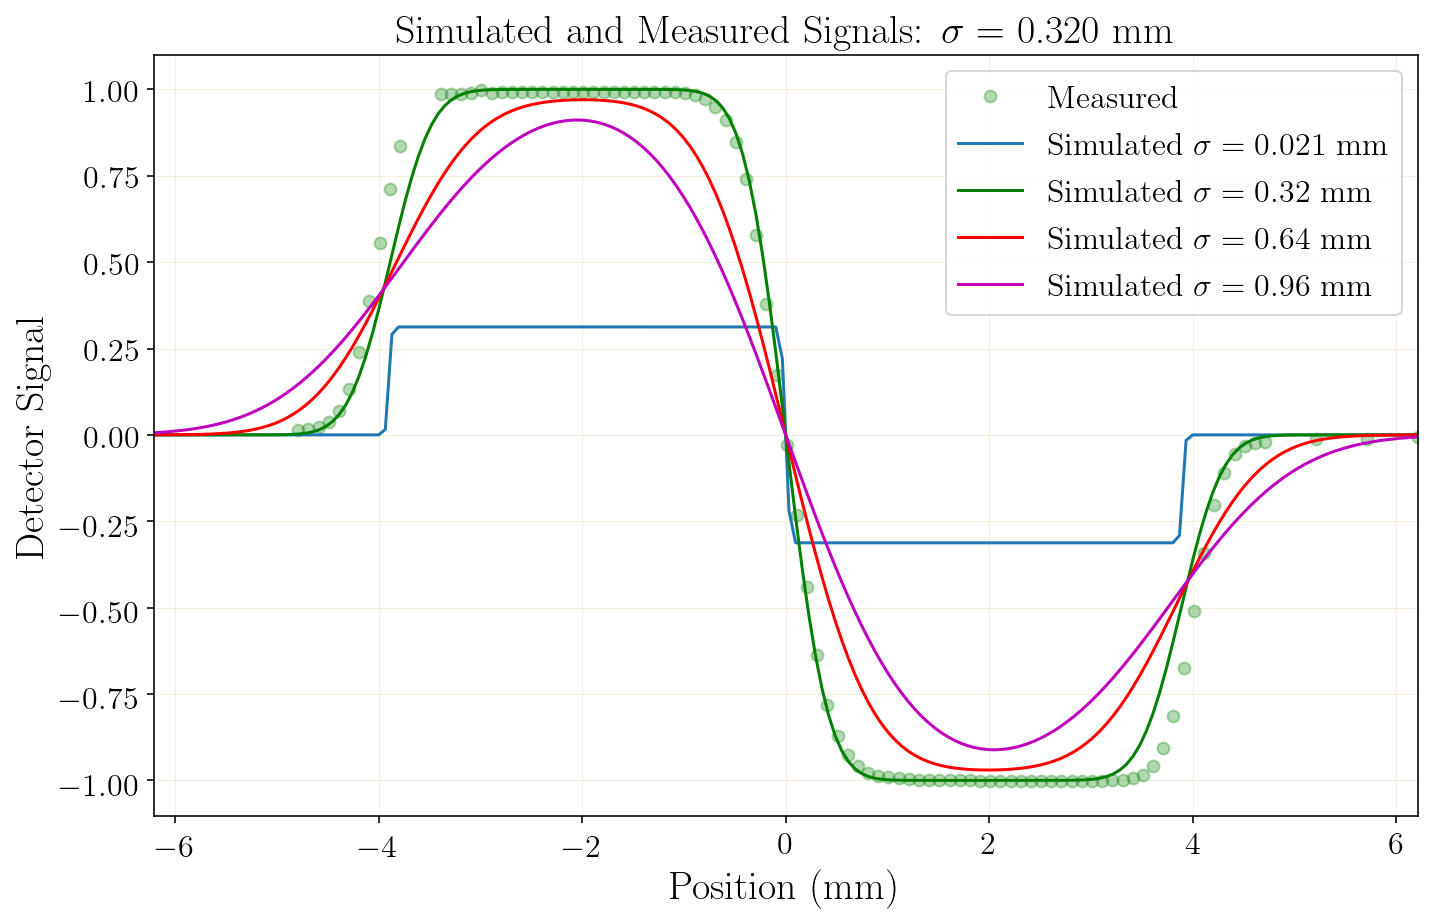

In [9]:
x_points, sum_sig, lr_sig, tb_sig = phy.signal_over_path(n, d0, δ, xmax, 0.021, track_func, n_samples,  ϵ)  # best guess to simulate the data
lr_sig = lr_sig/max(np.abs(lr))  
plt.close()
fig, ax = plt.subplots(figsize=(7*golden_ratio, 7))
ax.plot(calibration_data['dx'], calibration_data['dT-B'], 'go', label='Measured', alpha=0.3)
ax.plot(x_points, lr_sig, label='Simulated $\sigma = 0.021$ mm')
ax.plot(xp, lr, '-g', label='Simulated $\sigma = 0.32$ mm')
ax.plot(x_2sig, lr_2sig, '-r', label='Simulated $\sigma = 0.64$ mm')
ax.plot(x_3sig, lr_3sig, '-m', label='Simulated $\sigma = 0.96$ mm')

legend = ax.legend(loc='upper right', fontsize=16)
# Put a nicer background color on the legend.
#legend.get_frame().set_facecolor('oldlace')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel(r'Detector Signal', fontsize=20)
plt.xlabel(r'Position (mm)', fontsize=20)
plt.title(r'Simulated and Measured Signals: $\sigma$ = 0.320 mm', fontsize=20)
plt.xlim(-xmax, +xmax)
plt.grid(color='wheat', linestyle='-', linewidth=0.25)
plt.show()

### Common sense checks on the code: Quantitative
If we create an imaginary detector with radius 10.0 mm, with a gap of $\delta = 10^{-12}$ mm (i.e. negligible), and a small beam radius (say $\sigma = 2.0$ mm), 
we would expect that phy.compute_signals(n, d0, δ, beam, plot_signal=False) will return a sum_signal of very close to 1.0 (since almost the entire beam energy falls on the detector, and the laser beam profile is a 2d normalized gaussian. Remember, the laser beam is Gaussian, so a $\sigma = 2.0$ mm means that most of the beam energy will be within $2\sigma = 4\;\mathrm{mm}$ of the origin---this is why we expect the signal to be roughly equal to 1.0. If I made the gaussian beam radius 3.9 mm (the radius of the detector), we'd get a smaller signal (because a larger amount of the total energy falls outside the detector.) Three calls set up the problem and setting the plot_signal flag to True allows us to see the beam masked by the detector. We expect a sum signal close to 1.0, and left minus right and top minus bottom to be zero.

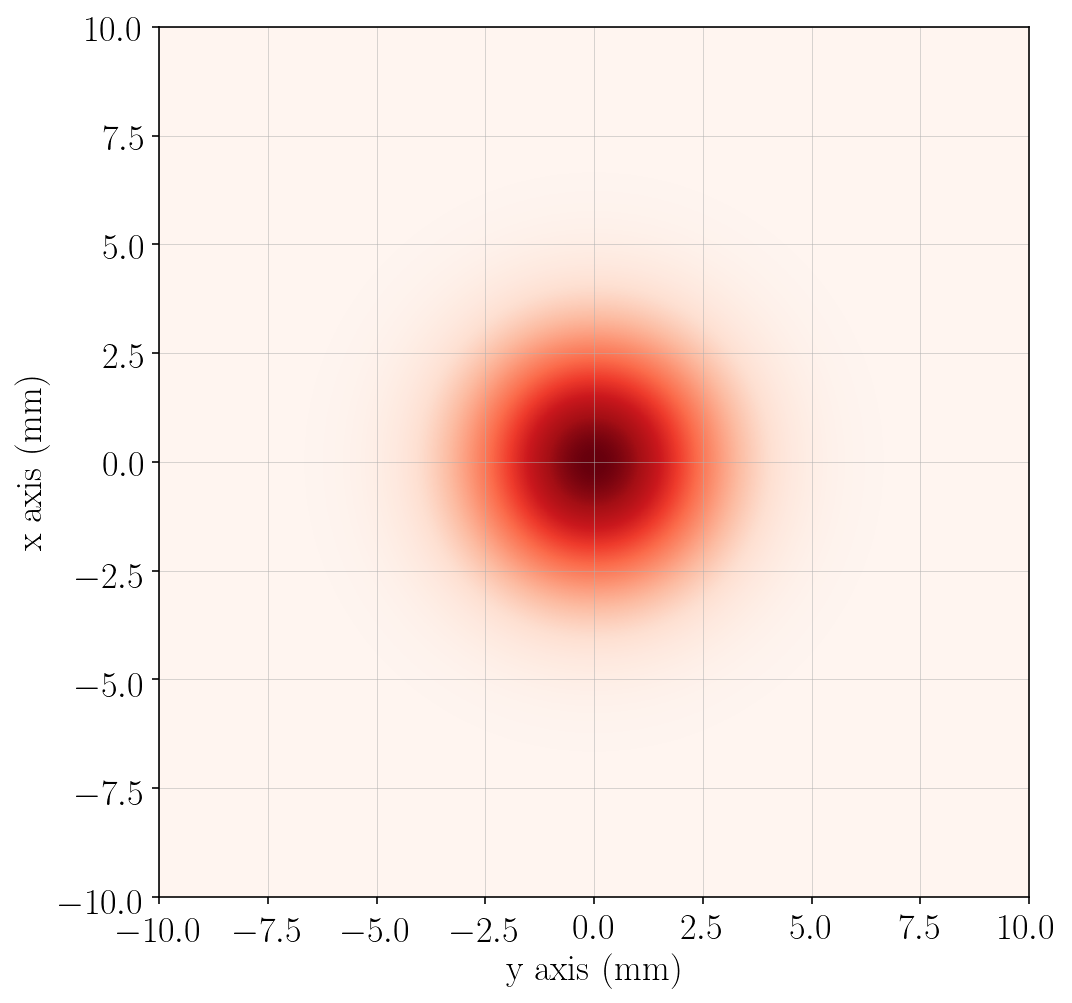

sum, L-R, T-B:  0.9999962745833688 1.1102230246251565e-16 -1.6653345369377348e-16


In [10]:
from QuadCellDetector_Spyder import physics as phy
x, y, active_area = phy.create_detector(2000, 20.0, 1e-12, ϵ=1e-14)   # create detector arrays
beam = phy.laser(x, y, 0.0, 0.0, 2.0)  # make a beam of width 2.0 mm centered on the origin
sum_signal, l_r, t_b = phy.compute_signals(2000, 20.0, 1e-12, beam, plot_signal=True)
print("sum, L-R, T-B: ", sum_signal, l_r, t_b)

Now execute the code with a gap $\delta = 0.2$ mm; you can see the masked out areas, and you see that the
sum signal decreases while the others remain essentially unchanged.

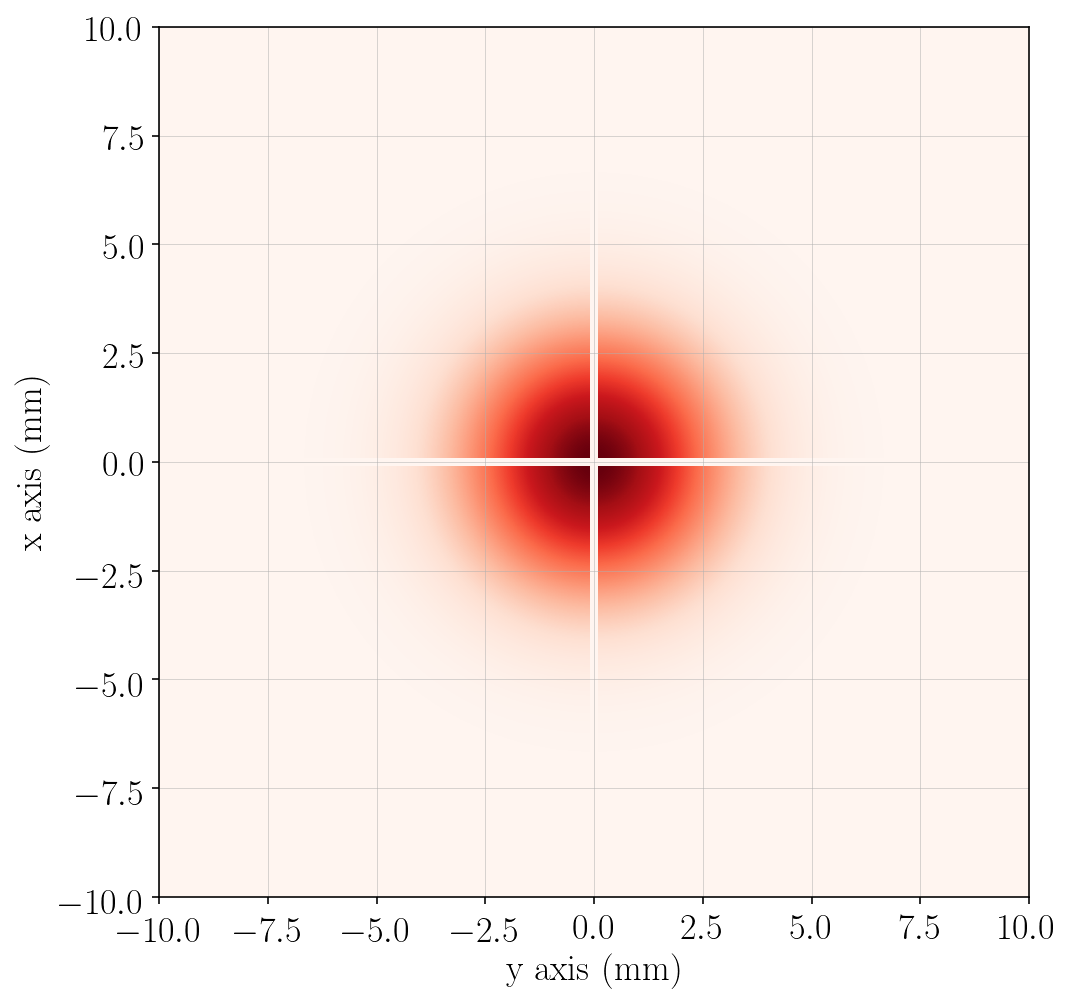

sum, L-R, T-B:  0.9218312411669368 -6.661338147750939e-16 1.6653345369377348e-16


In [11]:
x, y, active_area = phy.create_detector(2000, 20.0, 0.2, ϵ=1e-14)   # create detector arrays
beam = phy.laser(x, y, 0.0, 0.0, 2.0)  # make a beam of width 2.0 mm centered on the origin
sum_signal, l_r, t_b = phy.compute_signals(2000, 20.0, 0.2, beam, plot_signal=True)
print("sum, L-R, T-B: ", sum_signal, l_r, t_b)

## Slope at the zero crossing vs path across detector
Let's now use our best guess for our beam width $\sigma = 0.32\;\mathrm{mm}$, and see what happens for three scenarios:
1. Beam across y=0    # center of detector
2. Beam across y=d0/8 # 1/4 of radius
3. Beam across y=d0/4 # 1/2 of radius

In [44]:
from QuadCellDetector_Spyder import physics as phy
#########   Simulation Parameters:
n = 2*phy.n_critical(d0, δ)   # choose a reasonable minimum n value
ϵ = 1E-14                     # fudge factor due to roundoff error in case where δ = 2Δ
Δ = d0/n                      # grid size for simulation
xmax = x_max                  # maximum horizontal displacement of beam from origin in actual data
n_samples = 2*data_length     # number of sample points set to twice the number as in actual data
track_func1 = phy.CENTER_PATH  # function in physics.py that describes the y coordinate of the beam 
track_func2 = phy.QUARTER_PATH
track_func3 = phy.HALF_PATH
#
print("Building: ", n, "by", n, " Array")
print("Pixel Size: Δ = %.6f " % (Δ))
print("Sampling response from -", xmax, " to +", xmax, " in ", n_samples, " steps")
#
#   Now build the detector and return the detector response for a gaussian
#   beam centered at (xc, yc) illumninating the detector. I will compute three different 
#   scenarios (different beam widths)
#   get the start time so we can time the code execution:
start_time = time.time()
   
xp, s, lr, tb = phy.signal_over_path(n, d0, δ, xmax, σ, track_func1, n_samples,  ϵ)  # best guess to simulate the data; ϵ is an optional parameter
x_2sig, sum_2sig, lr_2sig, tb_2sig = phy.signal_over_path(n, d0, δ, xmax, σ, track_func2, n_samples, ϵ)  # simulation results for 2 times wider beam
x_3sig, sum_3sig, lr_3sig, tb_3sig = phy.signal_over_path(n, d0, δ, xmax, σ, track_func3, n_samples, ϵ)  # simulation results for 2 times wider beam
#lr = lr/max(np.abs(lr))     # scale all three left minus right signals by the maximum value of the smallest beam radius.
#lr_2sig = lr_2sig/max(np.abs(lr))
#lr_3sig = lr_3sig/max(np.abs(lr))
print("Runtime = %s seconds ---" % round(time.time() - start_time, 2))

Building:  744 by 744  Array
Pixel Size: Δ = 0.010484 
Sampling response from - 6.21  to + 6.21  in  192  steps
Runtime = 21.59 seconds ---


<function matplotlib.pyplot.show(*args, **kw)>

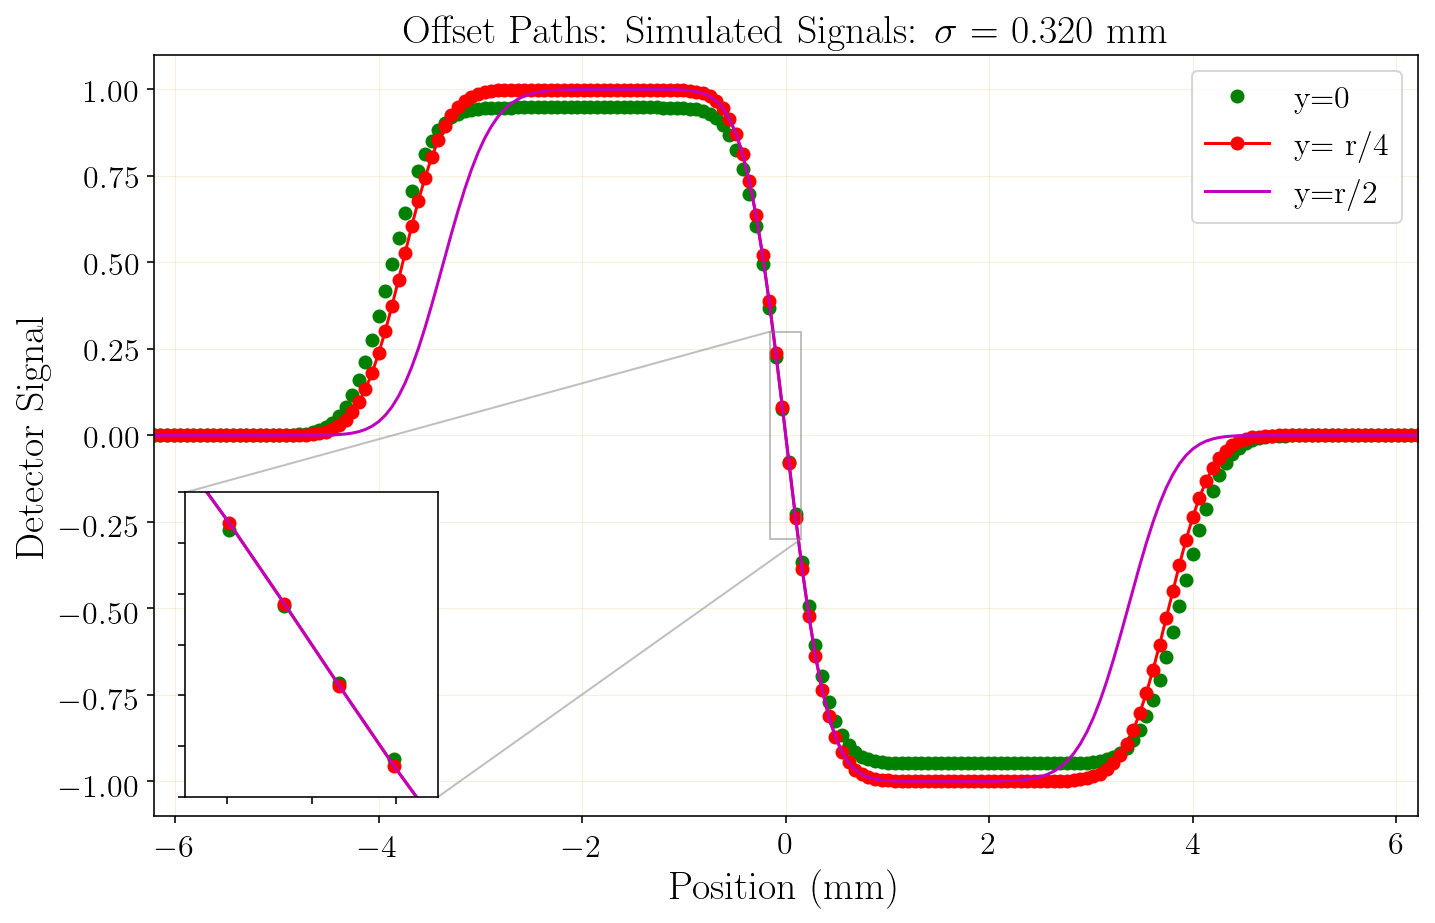

In [45]:
fig, ax = plt.subplots(figsize=(7*golden_ratio, 7))

ax.plot(xp, lr, 'go', label=' y=0')
ax.plot(x_2sig, lr_2sig, '-ro', label=' y= r/4')
ax.plot(x_3sig, lr_3sig, '-m', label=' y=r/2')

legend = ax.legend(loc='upper right', fontsize=16)
# Put a nicer background color on the legend.
#legend.get_frame().set_facecolor('oldlace')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel(r'Detector Signal', fontsize=20)
plt.xlabel(r'Position (mm)', fontsize=20)
plt.title(r'Offset Paths: Simulated Signals: $\sigma$ = 0.320 mm', fontsize=20)
plt.xlim(-xmax, +xmax)
plt.grid(color='wheat', linestyle='-', linewidth=0.25)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
axins = ax.inset_axes([0.025, 0.025, 0.20, 0.4])
axins.plot(xp, lr, 'go')
axins.plot(x_2sig, lr_2sig, '-ro')
axins.plot(x_3sig, lr_3sig, '-m')
# sub region of the original image
x1, x2, y1, y2 = -0.15, 0.15, -0.3, +0.3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

ax.indicate_inset_zoom(axins)


plt.show

## Implications of the detector design
Typically, quadrant cell photodiodes are used to detect when a beam is centered on the detector; when the sum signal is high and the (top - bottom) and (left - right) signals are at zero, we know the beam is centered. In this way, the detector can be used as a position or allignment detector. One can also use the zero crossing point to measure the period of an object in an optical lever arrangement. In these cases, the overal shape of the signal is not so crucial. However there is a case where the signal shape **is** important.

### Small amplitude oscillations and signal distortion

Suppose the laser beam changes its position sinusoidally with a very small amplitude on the detector---so small that the oscillation lives in the nearly linear region at the center of the detector. Then, with the actual position of the beam given by 
$$ x(t) = A\sin\left(\frac{2\pi}{T} t\right), $$
the (left - right) voltage signal *change* will be approximately
$$ V_{L-R} \approx \left(\frac{dV}{dx}\bigg\rvert_0\right)A\sin\left(\frac{2\pi}{T} t\right),$$
where $dV/dx$ is the slope of the (left - right) voltage signal at the optical zero crossing point. 
If this slope was constant, the detector signal would be sinusoidal for oscillation amplitudes confined to this central constant slope portion of the detector response curve.

However, for larger oscillation amplitudes, the detector response strays from this linear  region, and this will induce higher freqencies components into the output signal that
are not actually present in the motion of the object being tracked.

For example, suppose that our pendulum (period $\approx$ 40 seconds) actually oscillated sinusoidally in it's torsion mode with an amplitude of $\pm 0.5\;\mathrm{mm}$ (roughly confined to the linear region in the left-right signal.). Because of the detector response for our beam ($\sigma \approx 0.32\;\mathrm{mm}$, we will *not* obtain a (left - right) signal which is perfectly sinusoidal in time. It will have a small frequency component at a three times the fundamental (because of the slight square wave nature of the signal). This is not visible in the detector signal plot on the left, but the power spectrum shows it clearly. 

In [29]:
%load_ext autoreload
%autoreload 2
from QuadCellDetector_Spyder import physics as phy
tp, xp, s, lr, tb, f_lr, psd_lr, f_tb, psd_tb = phy.power_spectrum(n=600, d0=7.80, δ=0.042, ϵ=1e-14,\
                                               tmax=400, σ=0.320, track_func=phy.CENTER_PATH,\
                                               n_samples=600, amplitude=0.50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Building:  600 by 600  Array
Pixel Size: Δ = 0.013 
Runtime = 10.3 seconds ---


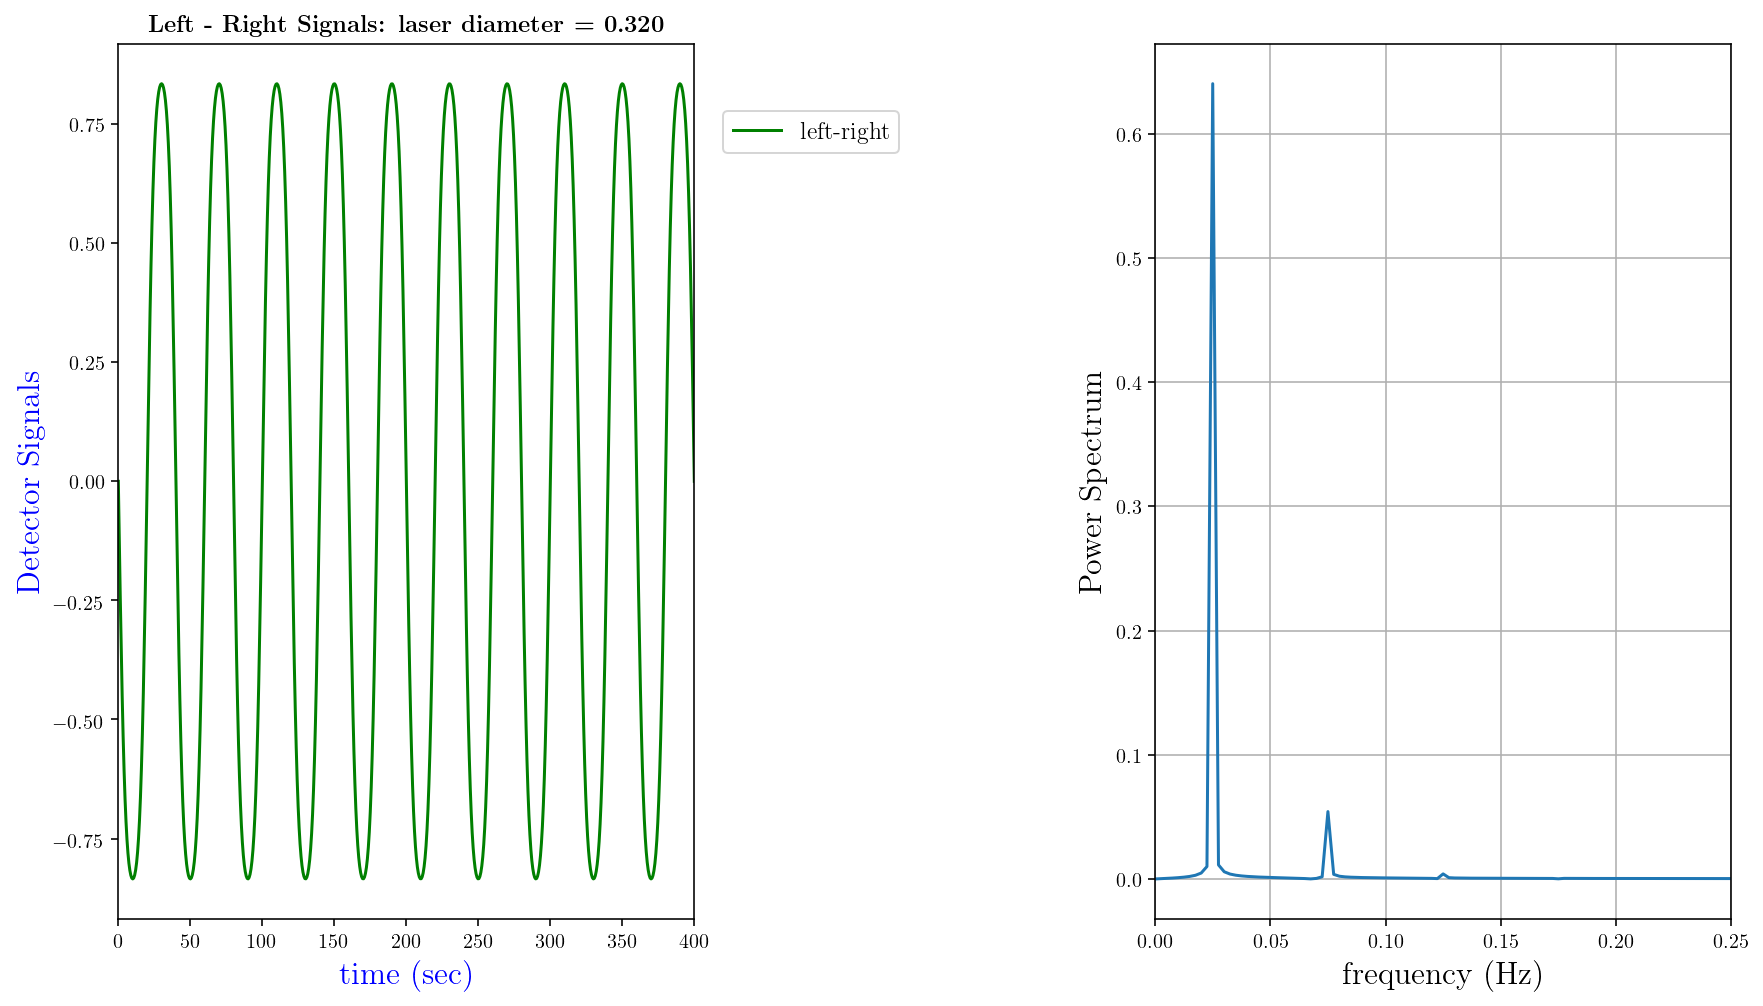

In [30]:
phy.plot_power_spectrum(tp, xp, s, lr, tb, f_lr, psd_lr, σ=0.320)

Now let's re-run this code with a larger amplitude (2.0 mm). Now you can clearly see the higher odd integer frequency components appearing.

In [31]:
from QuadCellDetector_Spyder import physics as phy
tp, xp, s, lr, tb, f_lr, psd_lr, f_tb, psd_tb= phy.power_spectrum(n=600, d0=7.80, δ=0.042, ϵ=1e-14,\
                                               tmax=400, σ=0.320, track_func=phy.CENTER_PATH,\
                                               n_samples=600, amplitude=2.0)

Building:  600 by 600  Array
Pixel Size: Δ = 0.013 
Runtime = 10.83 seconds ---


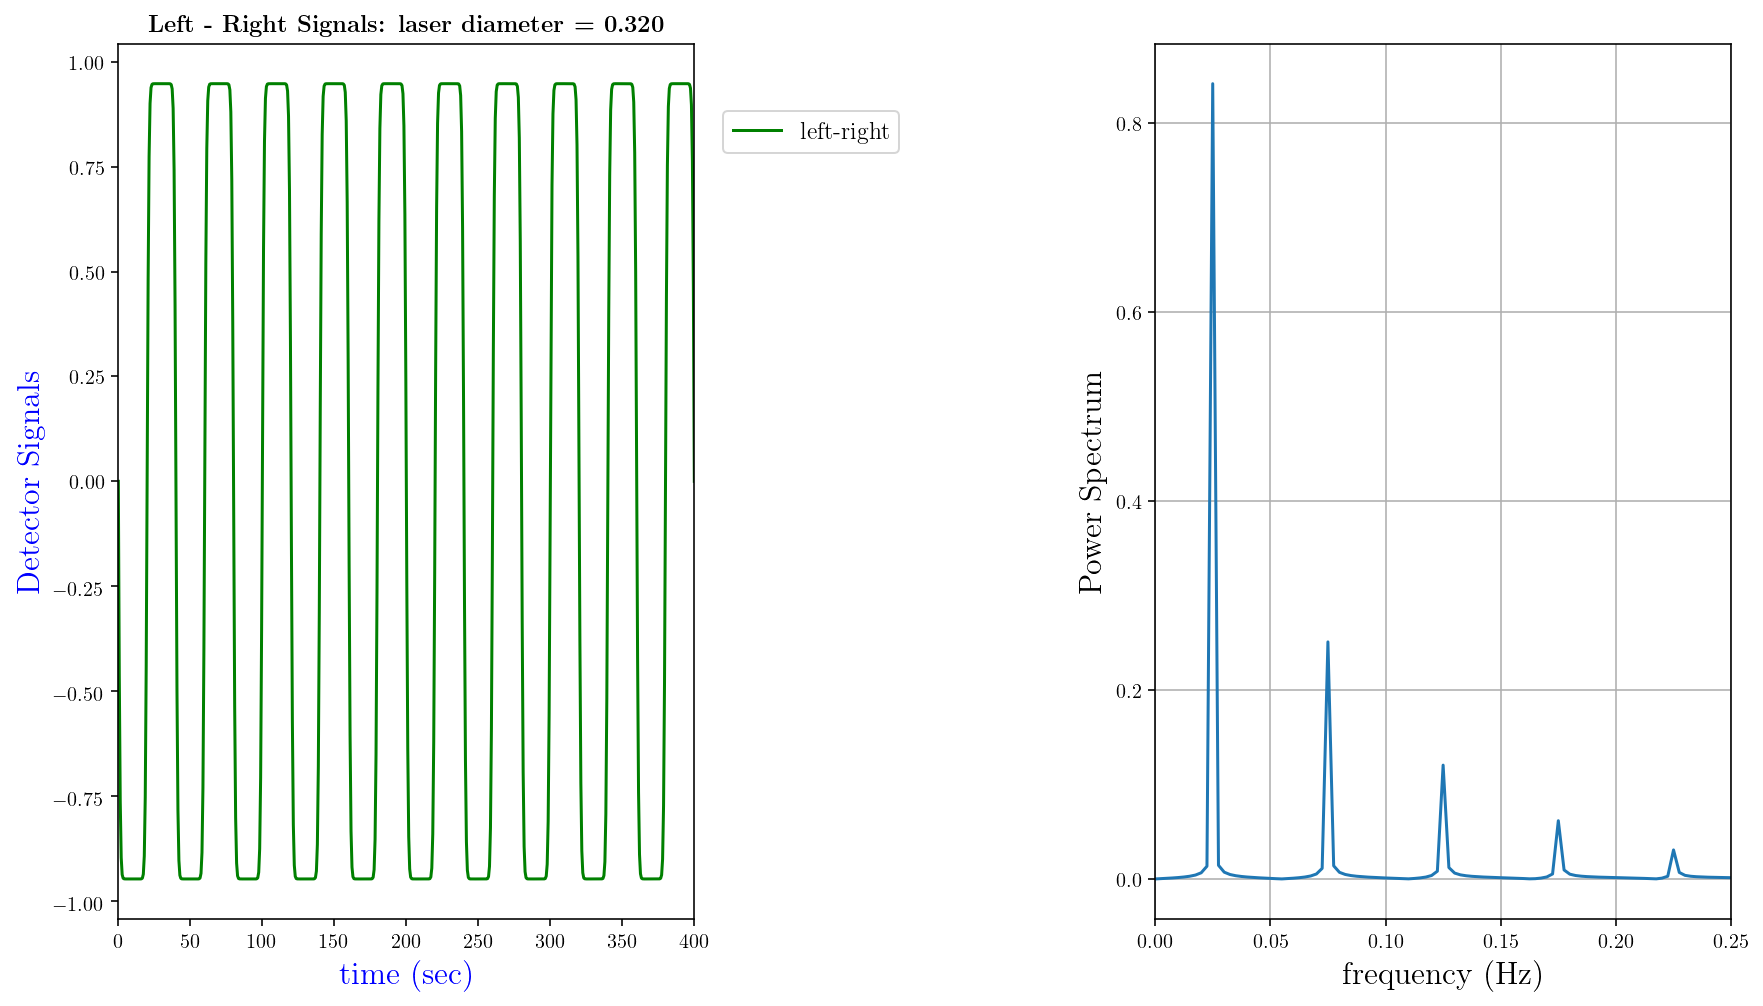

In [32]:
phy.plot_power_spectrum(tp, xp, s, lr, tb, f_lr, psd_lr, σ=0.320)

## Dealing with spurious frequency components
The upshot of this is that one has to be very careful when looking at the data from a quadrant cell detector. A straightforward power spectrum will display spurious frequency components that --- while a correct representation of the detector signal --- are not indicative of the underlying motion being tracked. There are several ways to deal with this issue:
1. increase the radius of the gaussian beam on the detector
2. reduce the amplitude of the motion of the pendulum
3. both (1) and (2)
4. filter out frequencies that are odd multiples of the fundamental.
5. if you are simply looking for the fundamental, just *ignore* the spurious frequencies.

### Increasing the radius of the laser beam
Let's run the previous simulation with a beam width of 4.00 mm. Clearly this reduces the amplitude and number of the spurious frequencies, however, we also lose power in the fundamental, so our signal to noise ratio will decrerase:

In [48]:
from QuadCellDetector_Spyder import physics as phy
tp, xp, s, lr, tb, f_lr, psd_lr, f_tb, psd_tb = phy.power_spectrum(n=600, d0=7.80, δ=0.042, ϵ=1e-14,\
                                               tmax=400, σ=4.00, track_func=phy.CENTER_PATH,\
                                               n_samples=600, amplitude=2.00)

Building:  600 by 600  Array
Pixel Size: Δ = 0.013 
Runtime = 9.82 seconds ---


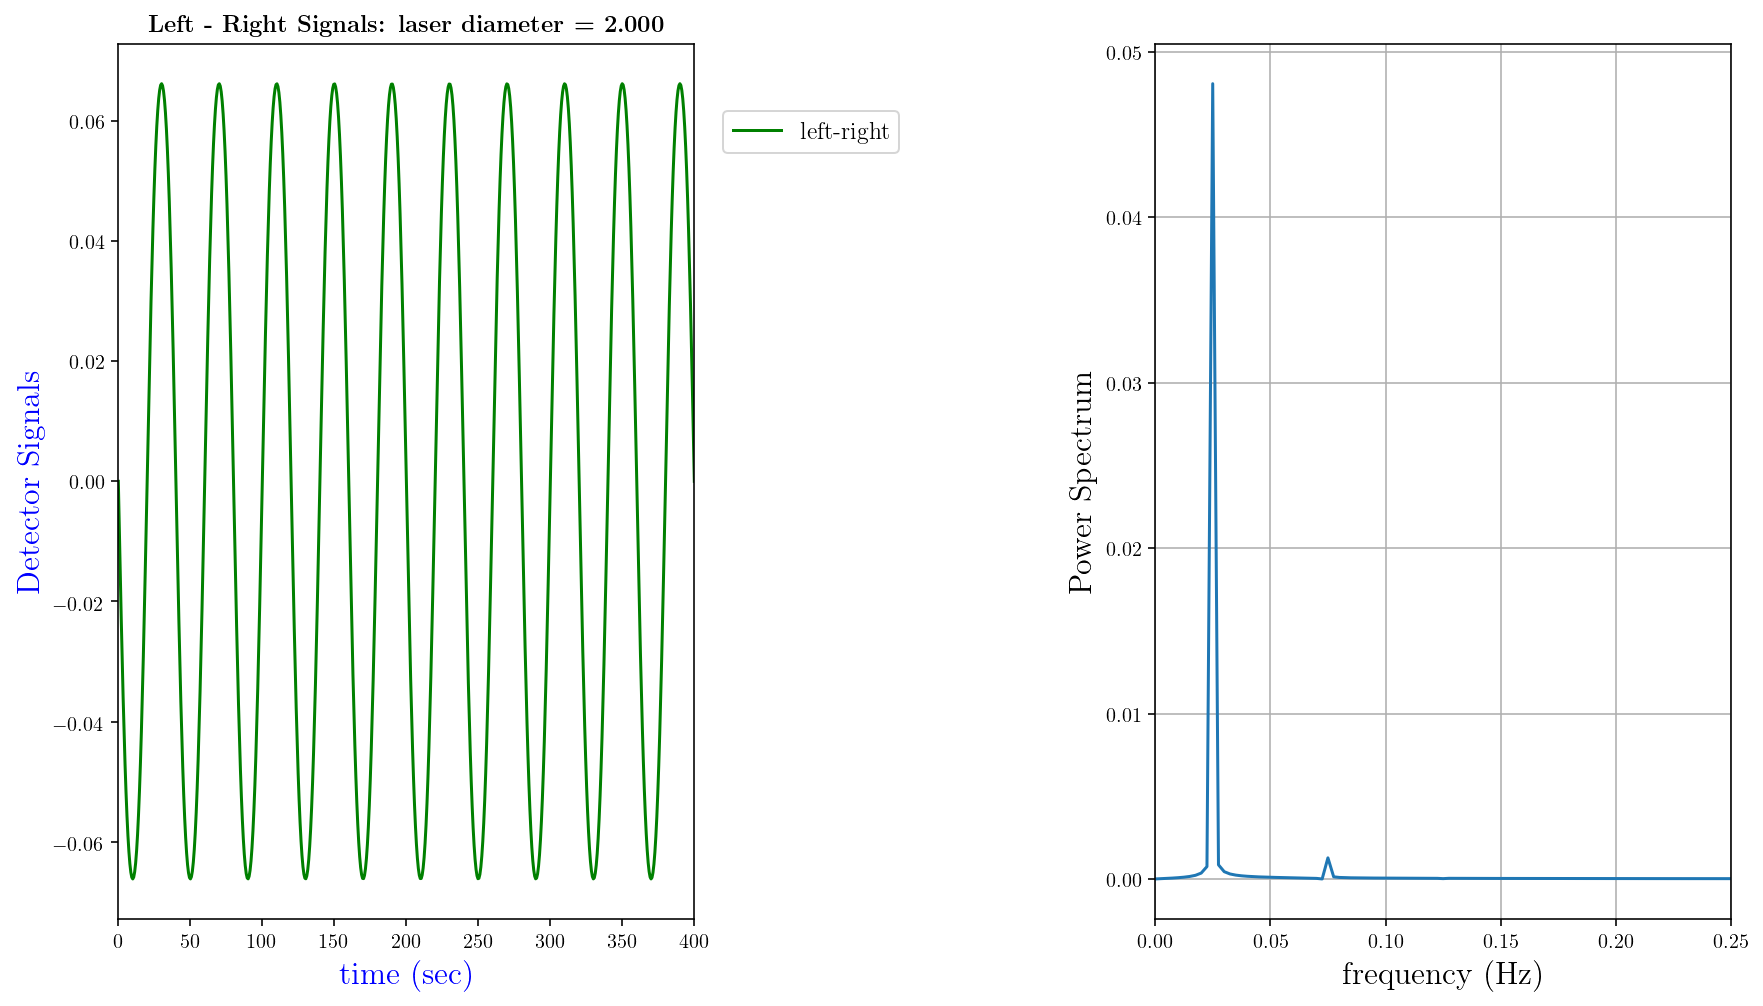

In [49]:
phy.plot_power_spectrum(tp, xp, s, lr, tb, f_lr, psd_lr, σ=2.00,fmax=0.25)

### Filtering out or ignoring spurious frequencies
This method is problematic at best except in the case where you only expect one fundamental frequency. 
In our case, we want to know all the normal modes of the pendulum, and this makes our picture much more complicated. 
For example, in the previous cases, the simulation had the pendulum track precisely across the midline of the detector. 
What if we change this so the the pendulum also oscillates up and down (amplitude of 0.5$d_0$, $\omega = 0.5$ Hz) 
as it tracks across? I'll use the previous simulation
with the only change being the path of the beam:

In [50]:
from QuadCellDetector_Spyder import physics as phy
tp, xp, s, lr, tb, f_lr, psd_lr, f_tb, psd_tb = phy.power_spectrum(n=600, d0=7.80, δ=0.042, ϵ=1e-14,\
                                               tmax=400, σ=2.00, track_func=phy.SIN_PATH,\
                                               n_samples=600, amplitude=2.0)

Building:  600 by 600  Array
Pixel Size: Δ = 0.013 
Runtime = 10.01 seconds ---


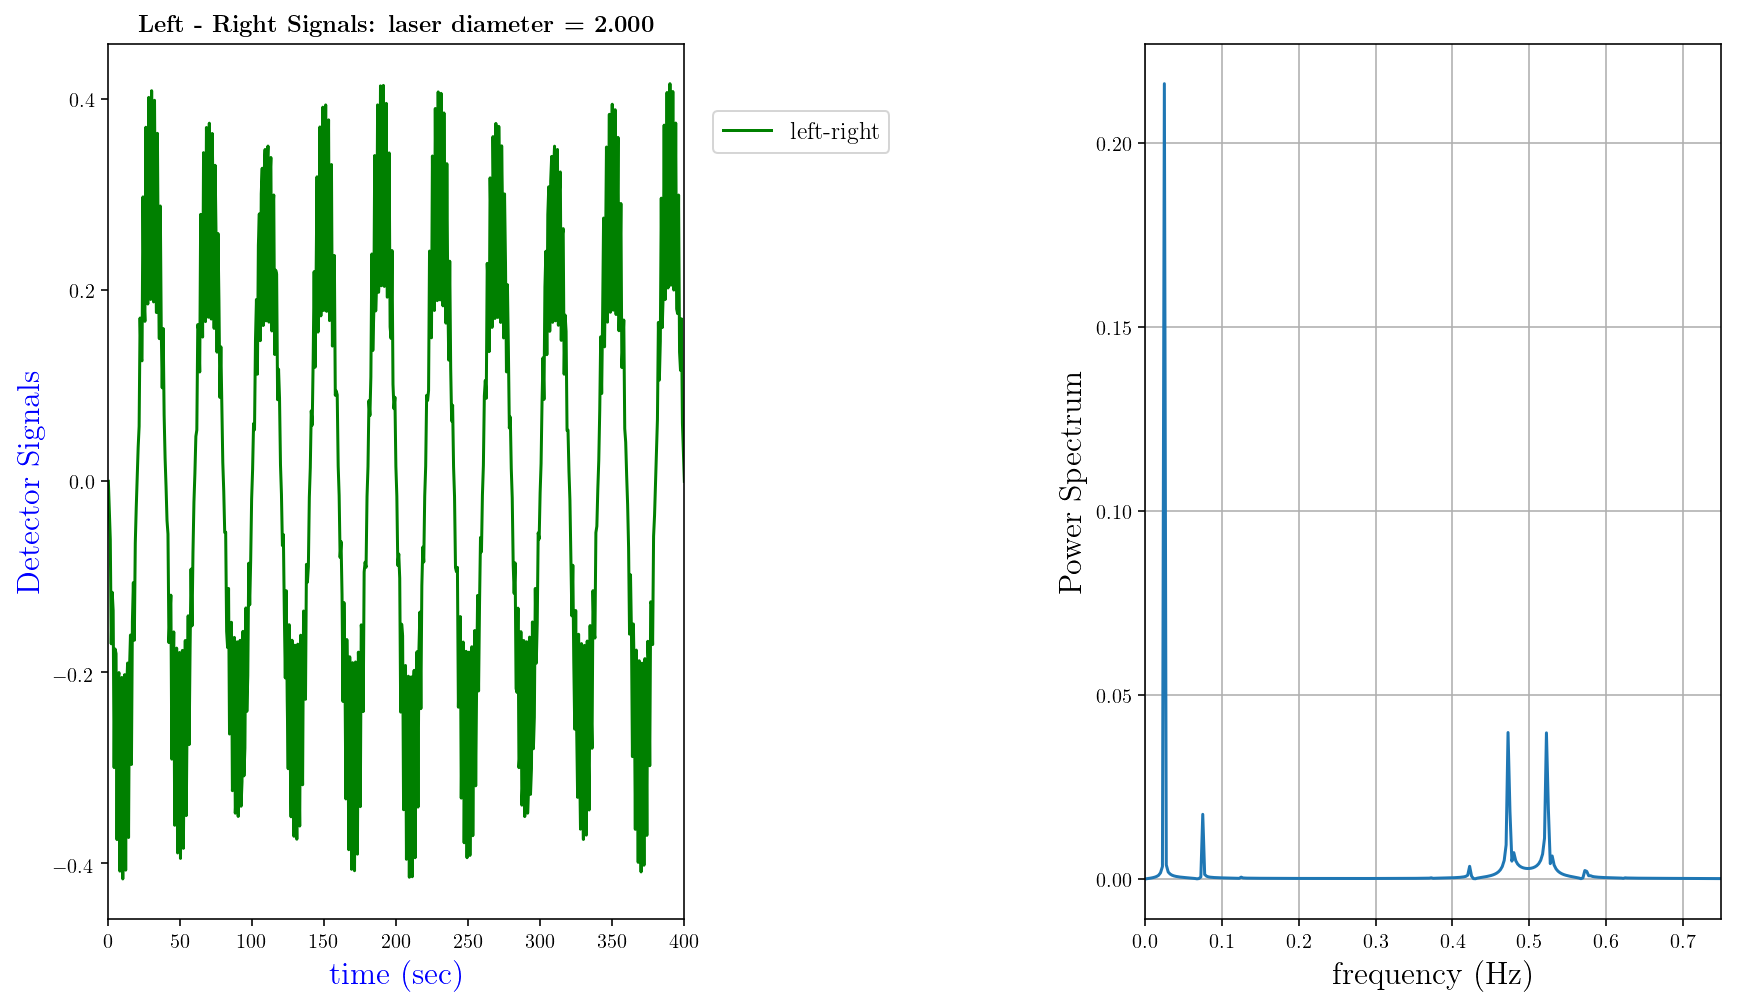

In [51]:
phy.plot_power_spectrum(tp, xp, s, lr, tb, f_lr, psd_lr, σ=2.00, fmax=0.75)

This vertical sinusoidal oscxillation does not seem to introduce a significant frequency component in the left-right signal; this is not surprising based on the "Offset Paths" plot made earlier. 
The vertical oscillation does, however show up in the top-bottom signal (at 0.5 Hz)

However, what if we decrease the spot size to 0.32 mm?

In [52]:
tp, xp, s, lr, tb, f_lr, psd_lr, t_tb, psd_tb = phy.power_spectrum(n=600, d0=7.80, δ=0.042, ϵ=1e-14,\
                                               tmax=400, σ=0.32, track_func=phy.SIN_PATH,\
                                               n_samples=600, amplitude=2.0)

Building:  600 by 600  Array
Pixel Size: Δ = 0.013 
Runtime = 9.88 seconds ---


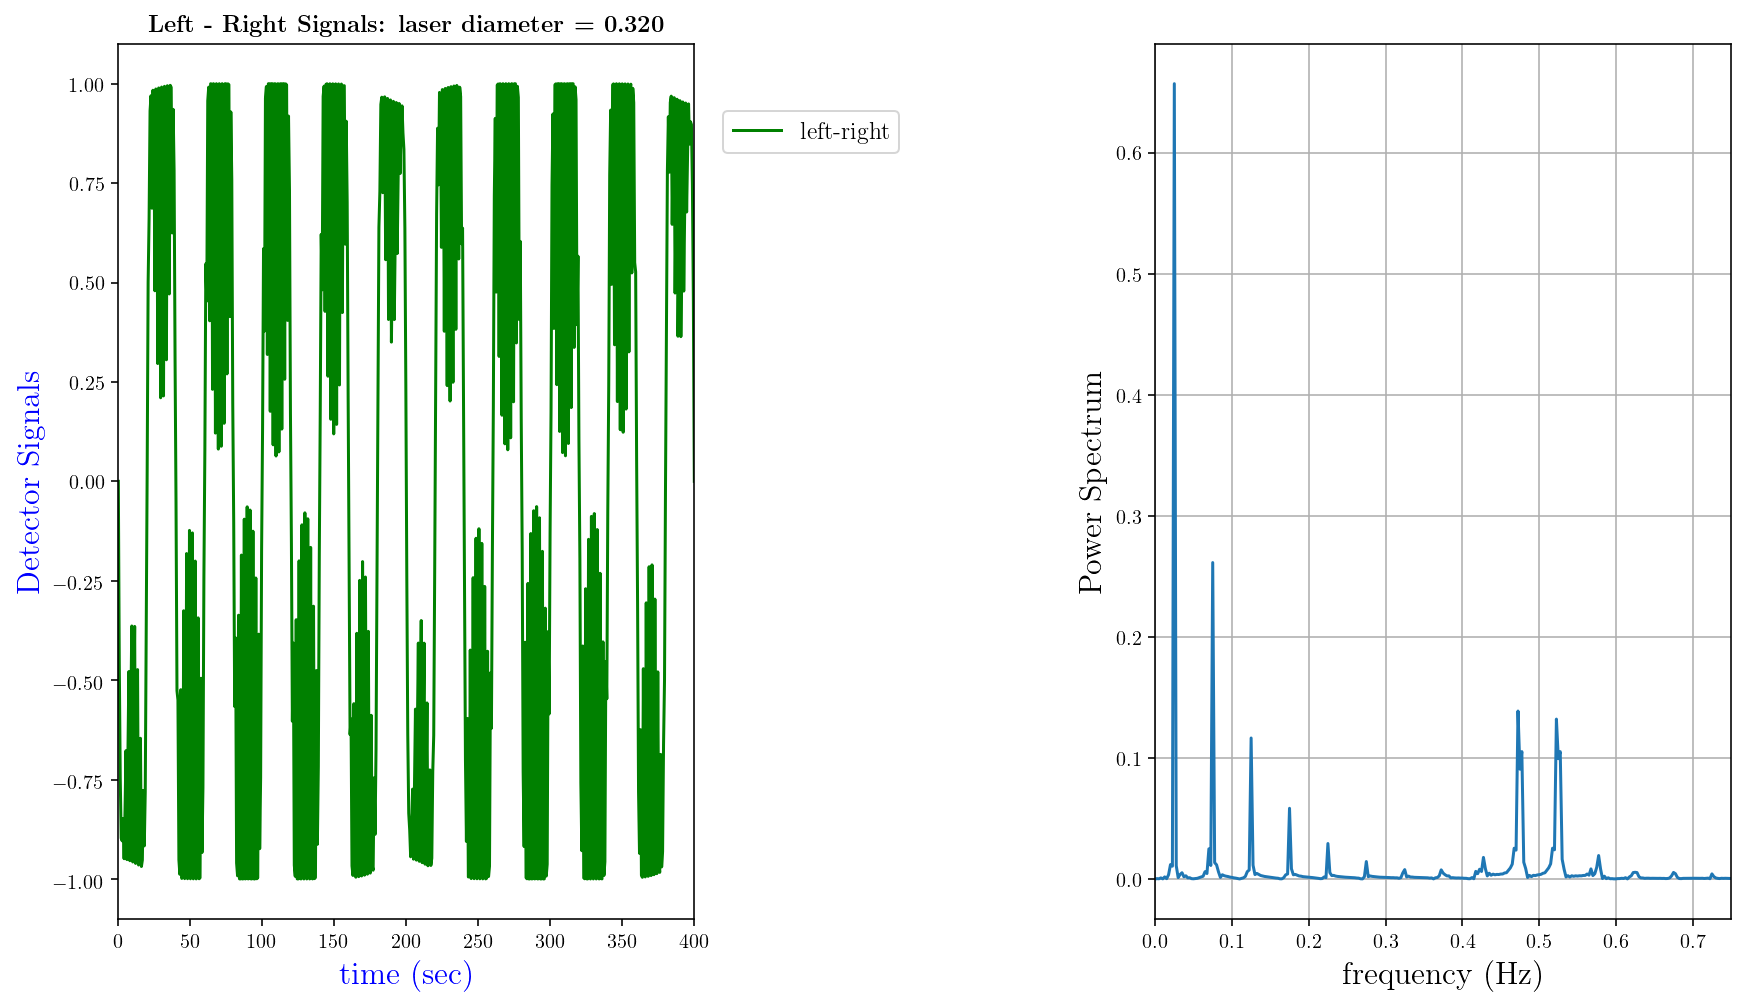

In [53]:
phy.plot_power_spectrum(tp, xp, s, lr, tb, f_lr, psd_lr, σ=0.320,fmax=0.75)

The top - bottom signal looks like:

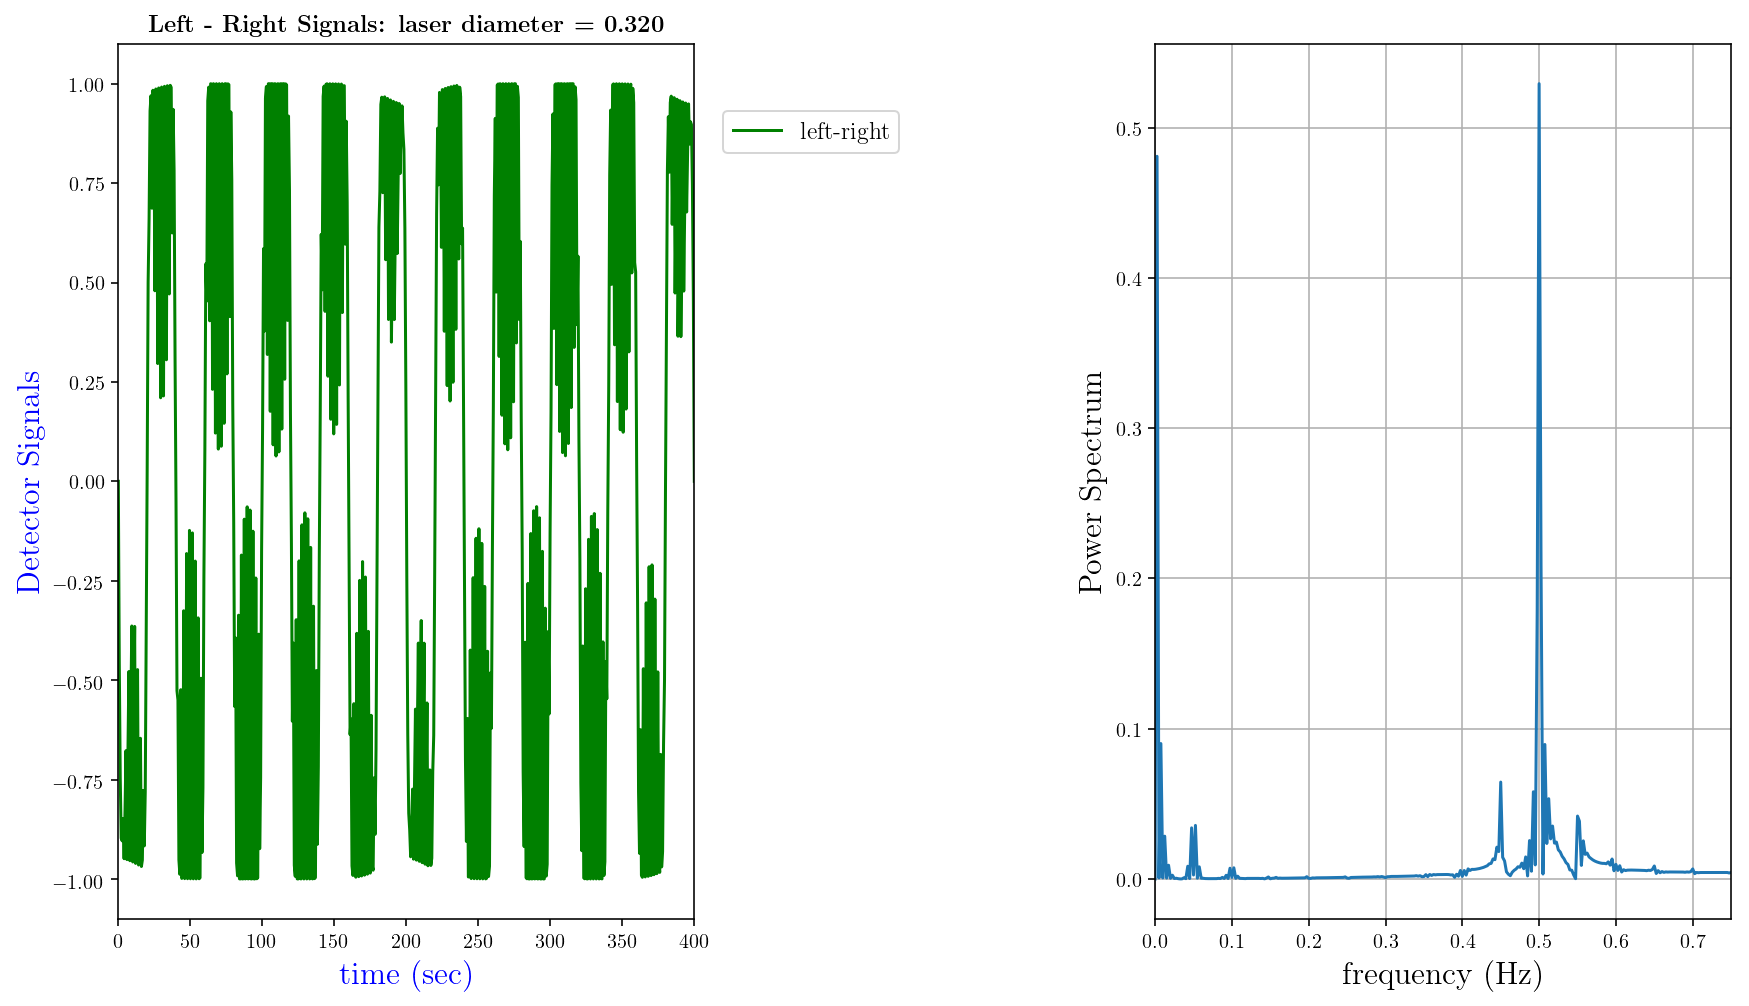

In [54]:
phy.plot_power_spectrum(tp, xp, s, lr, tb, f_tb, psd_tb, σ=0.320,fmax=0.75)

The above shows clearly that the situation can get very complicated. Clearly, we see a strong peak at the fundamental, but it becomes 
more difficult to understand which of the other peaks to pay attention to. 

## Conclusion
We've produced a reasonable computational model of a quadrant cell photodiode. Our model takes into account the in active gap region between all four quadrants and allows one to simulate the detector response for an arbitrary path across the detector. The computational model fits relatively well with the measured detector response when the beam is a way from the edges of the detector but does not seem to accurately show the falloff is the beam leaves the detector. This may very well be due to scattered light in our apparatus although I haven't verified this conjecture.

One thing the model does clearly show is that if one computes the power spectrum of the detector data, one has to be careful because of nonphysical frequency components which are introduced because of the detector response; these spurious frequency components are not present in the actual motion of the object in the optical lever.

